In [1]:
import random
from datetime import datetime

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

c:\python\python38\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from config import *

# Dataset

Using **CIFAR10** for our implementation.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Data Augmentation

In [5]:
from util import *

# Create Patches

This layer creates patches from input images. The layer also consists of two utility methods:
- `show_patched_image`: This utility function takes a batch of images and its corresponding patches, randomly choses a pair and plots it. This is useful for a sanity check.
- `reconstruct_from_patch`: This utility funciton takes the patches of a **single** image, and reconstructs it back into the original image. This is useful for the training monitor callback defined later.

In [6]:
from Patches import *

Index selected: 197.


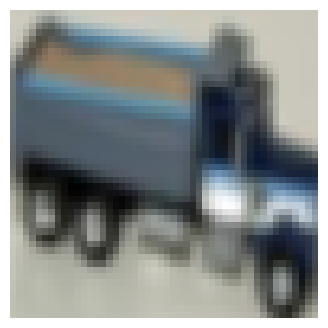

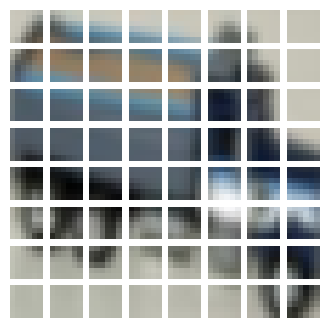

In [7]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmeneted_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = PatchesPre()

# Get the patches from the batched images.
patches = patch_layer(images=augmeneted_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmeneted_images, patches=patches)

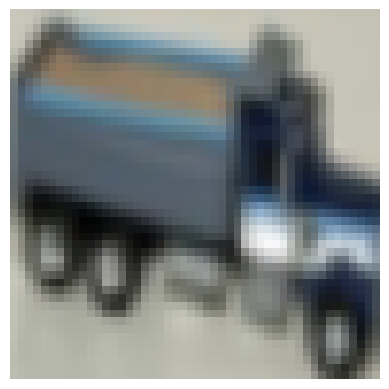

In [8]:
# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch Encoder

This layer deals with encoding the pathces and adding the positional embedding too. The layer holds two utility functions:
- `get_random_indices`: This function provides randomly sampled mask and unmask indices.
- `show_masked_image`: A utility function that plots a random masked image.

In [9]:
# Create the patch encoder layer.
patch_encoder = PatchEncoderPre()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

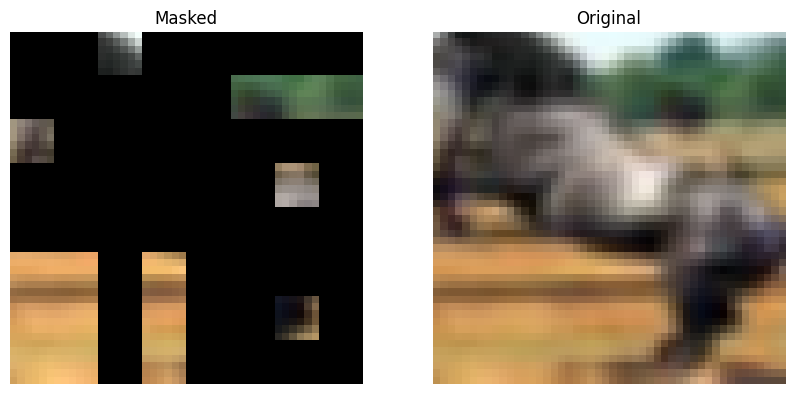

In [10]:
# Show a maksed patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmeneted_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

# MLP - Encoder - Decoder - MaskedAutoEncoder Model

In [11]:
from model import *

# Model init

In [12]:
keras.backend.clear_session()

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = PatchesPre()
patch_encoder = PatchEncoderPre()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

In [13]:
from TrainMonitor import *
# Taking a batch of test inputs to measure model's progress.


In [14]:
from WarmUpCosine import *

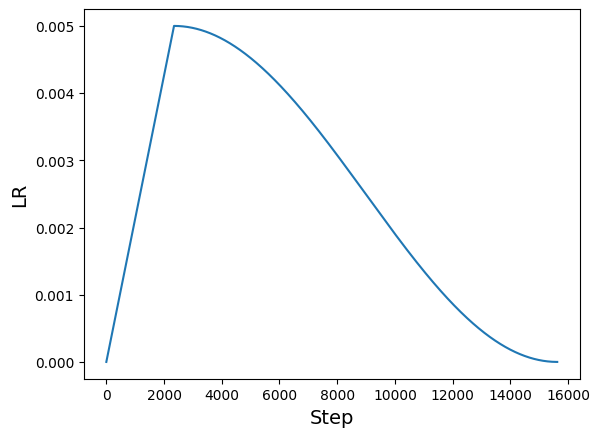

In [15]:
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_steps = int(total_steps * 0.15)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [16]:
timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

train_callbacks = [
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}"),
    TrainMonitor(test_ds, epoch_interval=5),
]

# Compilation and training

In [17]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 0.0507 - mae: 0.1806
Idx chosen: 154


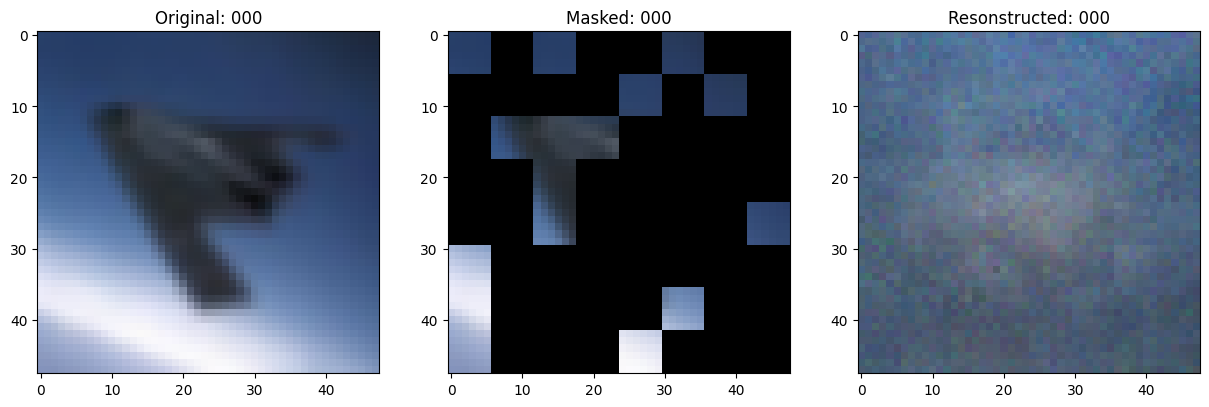

157/157 [==============================] - 15s 61ms/step - loss: 0.0506 - mae: 0.1806 - val_loss: 0.0420 - val_mae: 0.1635
Epoch 2/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0366 - mae: 0.1500 - val_loss: 0.0358 - val_mae: 0.1460
Epoch 3/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0315 - mae: 0.1365 - val_loss: 0.0303 - val_mae: 0.1344
Epoch 4/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0279 - mae: 0.1266 - val_loss: 0.0274 - val_mae: 0.1248
Epoch 5/100
157/157 [==============================] - 8s 53ms/step - loss: 0.0256 - mae: 0.1207 - val_loss: 0.0254 - val_mae: 0.1189
Epoch 6/100
156/157 [============================>.] - ETA: 0s - loss: 0.0236 - mae: 0.1150
Idx chosen: 136


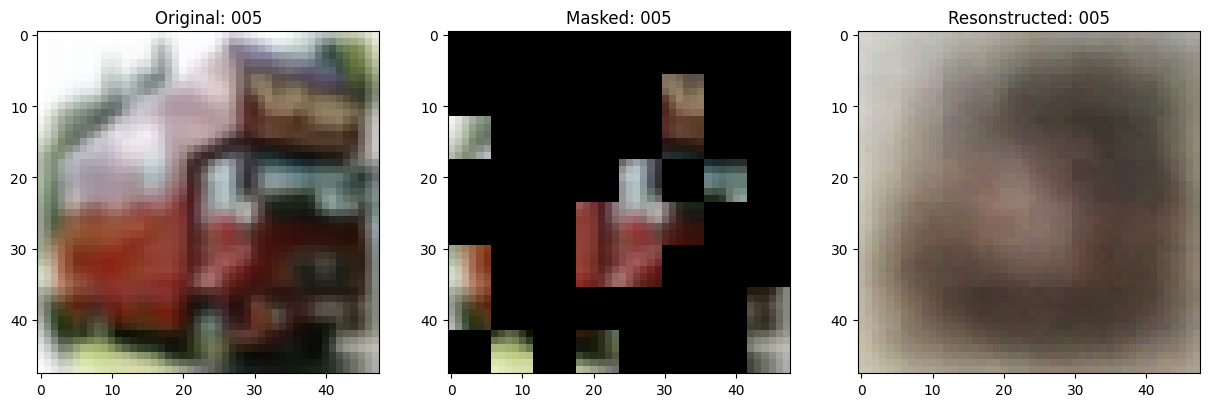

157/157 [==============================] - 9s 56ms/step - loss: 0.0236 - mae: 0.1150 - val_loss: 0.0238 - val_mae: 0.1161
Epoch 7/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0223 - mae: 0.1115 - val_loss: 0.0224 - val_mae: 0.1111
Epoch 8/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0213 - mae: 0.1085 - val_loss: 0.0216 - val_mae: 0.1087
Epoch 9/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0207 - mae: 0.1066 - val_loss: 0.0210 - val_mae: 0.1074
Epoch 10/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0202 - mae: 0.1051 - val_loss: 0.0209 - val_mae: 0.1064
Epoch 11/100
156/157 [============================>.] - ETA: 0s - loss: 0.0199 - mae: 0.1042
Idx chosen: 61


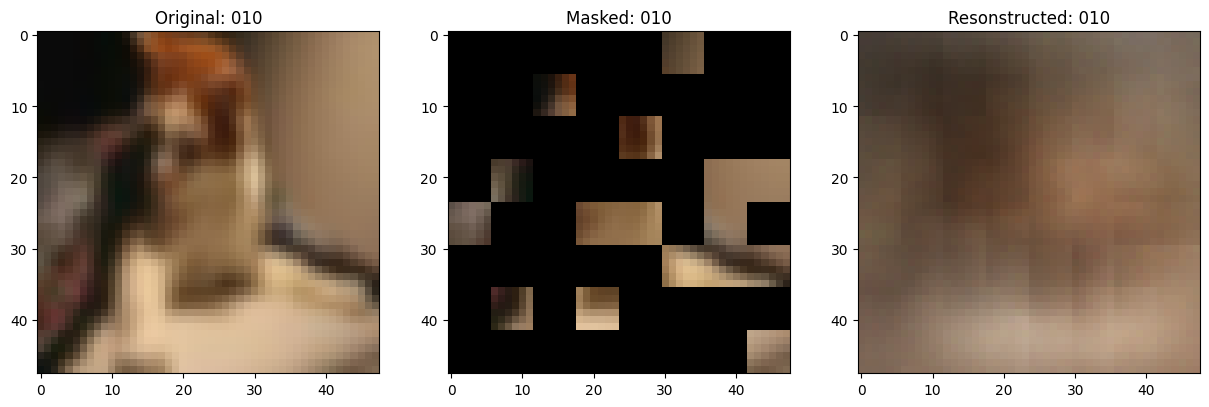

157/157 [==============================] - 9s 57ms/step - loss: 0.0199 - mae: 0.1042 - val_loss: 0.0206 - val_mae: 0.1051
Epoch 12/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0193 - mae: 0.1022 - val_loss: 0.0217 - val_mae: 0.1083
Epoch 13/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0193 - mae: 0.1023 - val_loss: 0.0207 - val_mae: 0.1073
Epoch 14/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0186 - mae: 0.1001 - val_loss: 0.0200 - val_mae: 0.1040
Epoch 15/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0186 - mae: 0.1001 - val_loss: 0.0194 - val_mae: 0.1023
Epoch 16/100
156/157 [============================>.] - ETA: 0s - loss: 0.0182 - mae: 0.0987
Idx chosen: 164


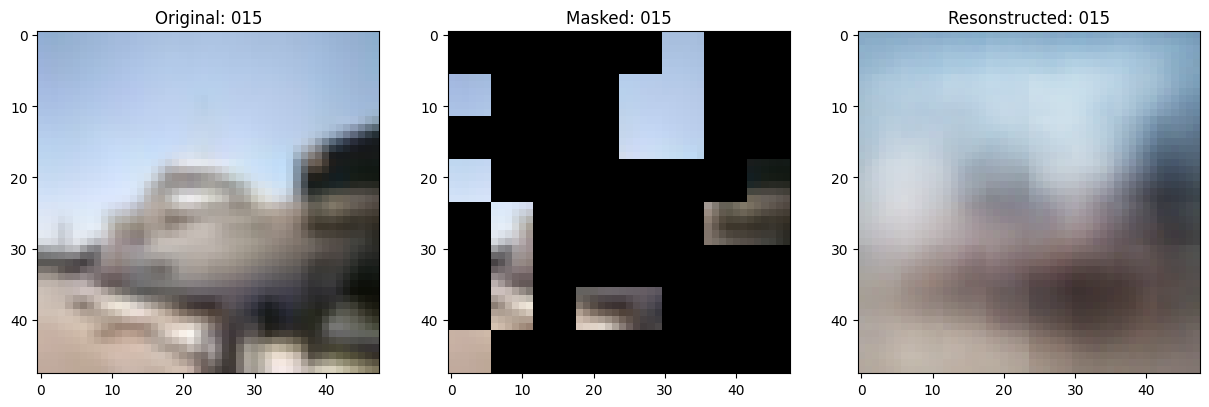

157/157 [==============================] - 9s 56ms/step - loss: 0.0182 - mae: 0.0987 - val_loss: 0.0187 - val_mae: 0.0997
Epoch 17/100
157/157 [==============================] - 9s 54ms/step - loss: 0.0179 - mae: 0.0978 - val_loss: 0.0186 - val_mae: 0.0991
Epoch 18/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0176 - mae: 0.0969 - val_loss: 0.0186 - val_mae: 0.0997
Epoch 19/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0174 - mae: 0.0960 - val_loss: 0.0186 - val_mae: 0.0998
Epoch 20/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0175 - mae: 0.0967 - val_loss: 0.0181 - val_mae: 0.0979
Epoch 21/100
157/157 [==============================] - ETA: 0s - loss: 0.0171 - mae: 0.0949
Idx chosen: 224


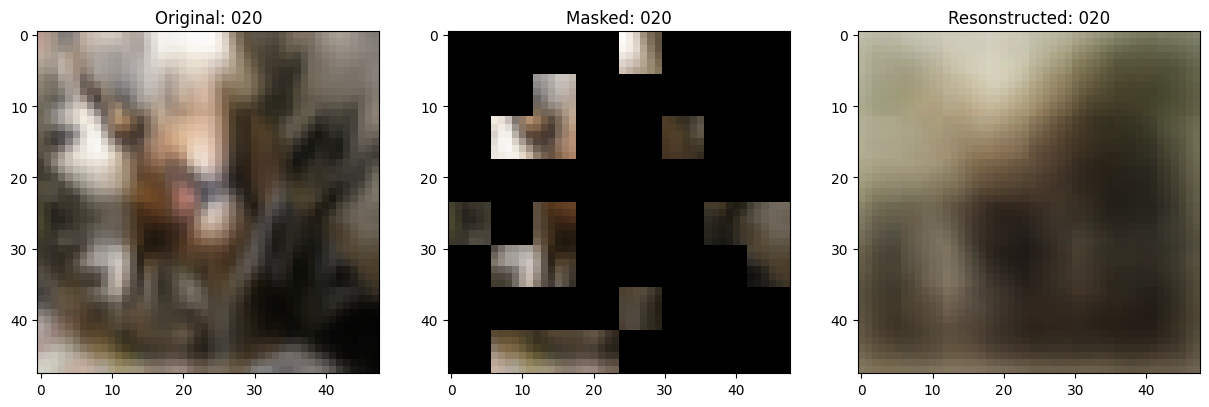

157/157 [==============================] - 9s 56ms/step - loss: 0.0171 - mae: 0.0949 - val_loss: 0.0181 - val_mae: 0.0977
Epoch 22/100
157/157 [==============================] - 9s 54ms/step - loss: 0.0169 - mae: 0.0945 - val_loss: 0.0179 - val_mae: 0.0959
Epoch 23/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0168 - mae: 0.0941 - val_loss: 0.0177 - val_mae: 0.0968
Epoch 24/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0167 - mae: 0.0936 - val_loss: 0.0176 - val_mae: 0.0968
Epoch 25/100
157/157 [==============================] - 9s 54ms/step - loss: 0.0164 - mae: 0.0929 - val_loss: 0.0173 - val_mae: 0.0953
Epoch 26/100
156/157 [============================>.] - ETA: 0s - loss: 0.0164 - mae: 0.0927
Idx chosen: 50


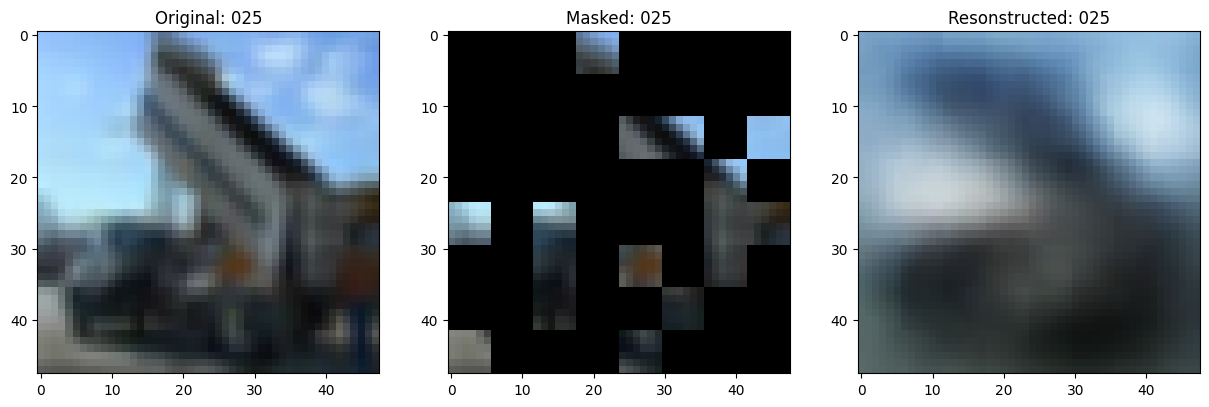

157/157 [==============================] - 9s 57ms/step - loss: 0.0164 - mae: 0.0927 - val_loss: 0.0174 - val_mae: 0.0954
Epoch 27/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0164 - mae: 0.0927 - val_loss: 0.0174 - val_mae: 0.0957
Epoch 28/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0163 - mae: 0.0922 - val_loss: 0.0170 - val_mae: 0.0939
Epoch 29/100
157/157 [==============================] - 8s 54ms/step - loss: 0.0162 - mae: 0.0920 - val_loss: 0.0172 - val_mae: 0.0939
Epoch 30/100
157/157 [==============================] - 9s 54ms/step - loss: 0.0164 - mae: 0.0928 - val_loss: 0.0175 - val_mae: 0.0957
Epoch 31/100
157/157 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0912
Idx chosen: 233


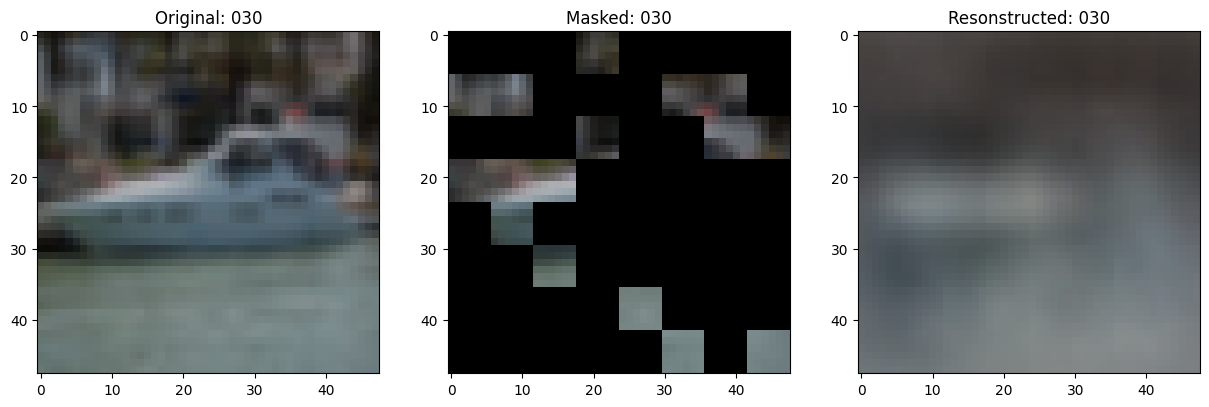

157/157 [==============================] - 9s 57ms/step - loss: 0.0160 - mae: 0.0912 - val_loss: 0.0166 - val_mae: 0.0930
Epoch 32/100
157/157 [==============================] - 9s 54ms/step - loss: 0.0158 - mae: 0.0907 - val_loss: 0.0170 - val_mae: 0.0947
Epoch 33/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0157 - mae: 0.0905 - val_loss: 0.0167 - val_mae: 0.0926
Epoch 34/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0157 - mae: 0.0902 - val_loss: 0.0165 - val_mae: 0.0918
Epoch 35/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0157 - mae: 0.0903 - val_loss: 0.0168 - val_mae: 0.0933
Epoch 36/100
157/157 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0903
Idx chosen: 171


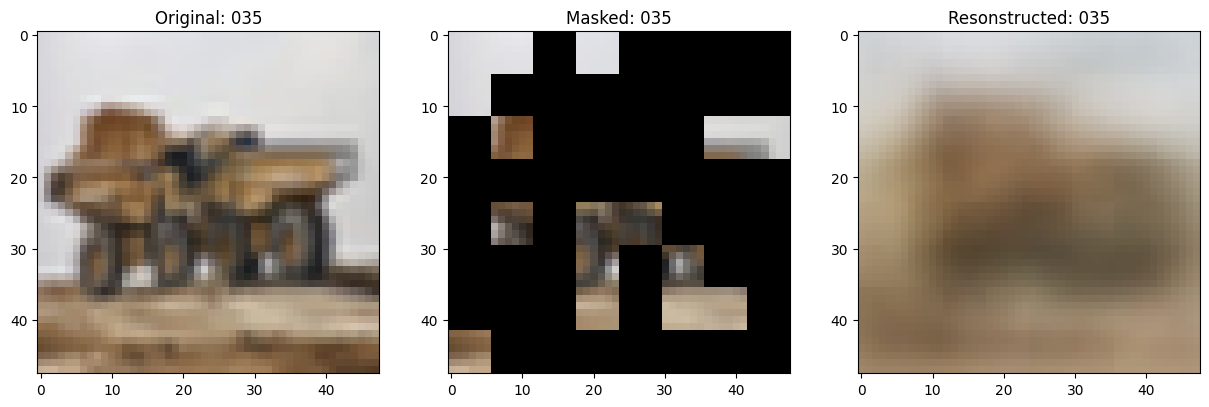

157/157 [==============================] - 9s 58ms/step - loss: 0.0157 - mae: 0.0903 - val_loss: 0.0170 - val_mae: 0.0956
Epoch 37/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0155 - mae: 0.0895 - val_loss: 0.0167 - val_mae: 0.0927
Epoch 38/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0155 - mae: 0.0896 - val_loss: 0.0165 - val_mae: 0.0927
Epoch 39/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0154 - mae: 0.0893 - val_loss: 0.0165 - val_mae: 0.0915
Epoch 40/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0152 - mae: 0.0886 - val_loss: 0.0163 - val_mae: 0.0926
Epoch 41/100
156/157 [============================>.] - ETA: 0s - loss: 0.0152 - mae: 0.0885
Idx chosen: 151


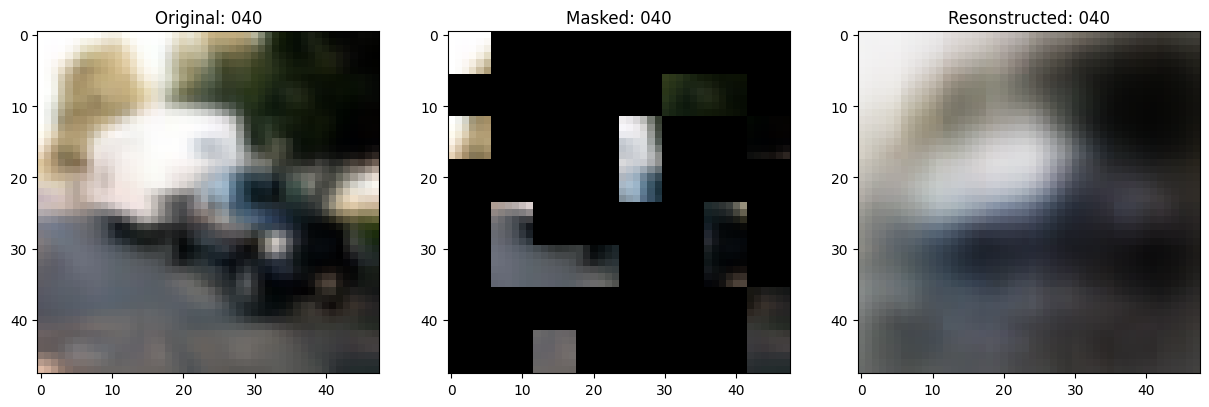

157/157 [==============================] - 9s 60ms/step - loss: 0.0152 - mae: 0.0885 - val_loss: 0.0166 - val_mae: 0.0923
Epoch 42/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0151 - mae: 0.0881 - val_loss: 0.0163 - val_mae: 0.0923
Epoch 43/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0151 - mae: 0.0881 - val_loss: 0.0163 - val_mae: 0.0908
Epoch 44/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0150 - mae: 0.0877 - val_loss: 0.0166 - val_mae: 0.0934
Epoch 45/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0150 - mae: 0.0877 - val_loss: 0.0160 - val_mae: 0.0903
Epoch 46/100
156/157 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0875
Idx chosen: 206


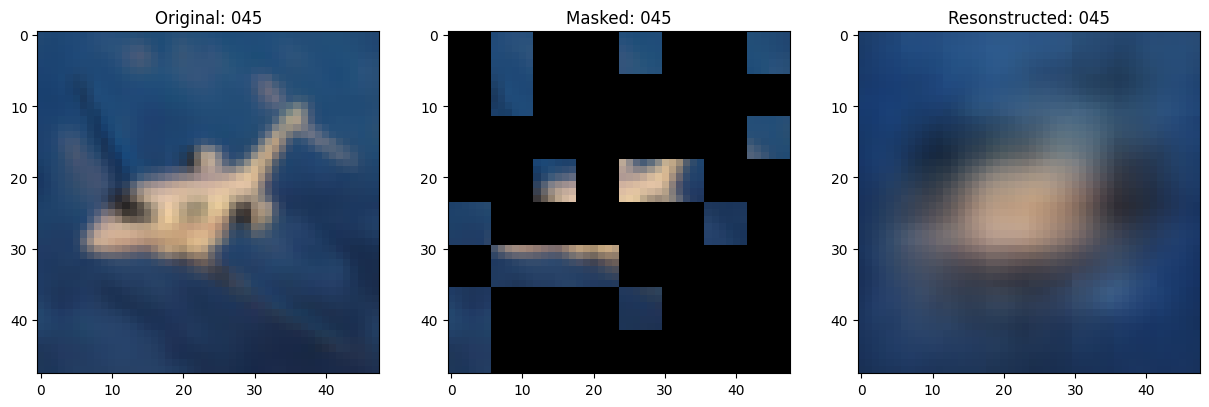

157/157 [==============================] - 10s 61ms/step - loss: 0.0149 - mae: 0.0875 - val_loss: 0.0158 - val_mae: 0.0895
Epoch 47/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0149 - mae: 0.0871 - val_loss: 0.0159 - val_mae: 0.0898
Epoch 48/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0147 - mae: 0.0865 - val_loss: 0.0159 - val_mae: 0.0900
Epoch 49/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0147 - mae: 0.0865 - val_loss: 0.0159 - val_mae: 0.0902
Epoch 50/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0146 - mae: 0.0863 - val_loss: 0.0161 - val_mae: 0.0901
Epoch 51/100
156/157 [============================>.] - ETA: 0s - loss: 0.0147 - mae: 0.0863
Idx chosen: 58


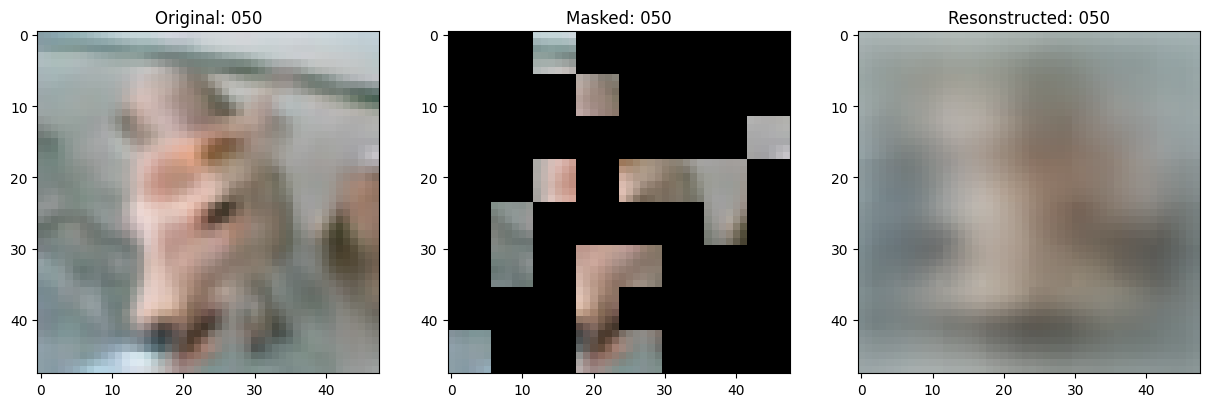

157/157 [==============================] - 9s 60ms/step - loss: 0.0147 - mae: 0.0863 - val_loss: 0.0159 - val_mae: 0.0905
Epoch 52/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0145 - mae: 0.0860 - val_loss: 0.0160 - val_mae: 0.0902
Epoch 53/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0144 - mae: 0.0854 - val_loss: 0.0155 - val_mae: 0.0883
Epoch 54/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0144 - mae: 0.0855 - val_loss: 0.0156 - val_mae: 0.0884
Epoch 55/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0143 - mae: 0.0850 - val_loss: 0.0159 - val_mae: 0.0912
Epoch 56/100
156/157 [============================>.] - ETA: 0s - loss: 0.0143 - mae: 0.0849
Idx chosen: 117


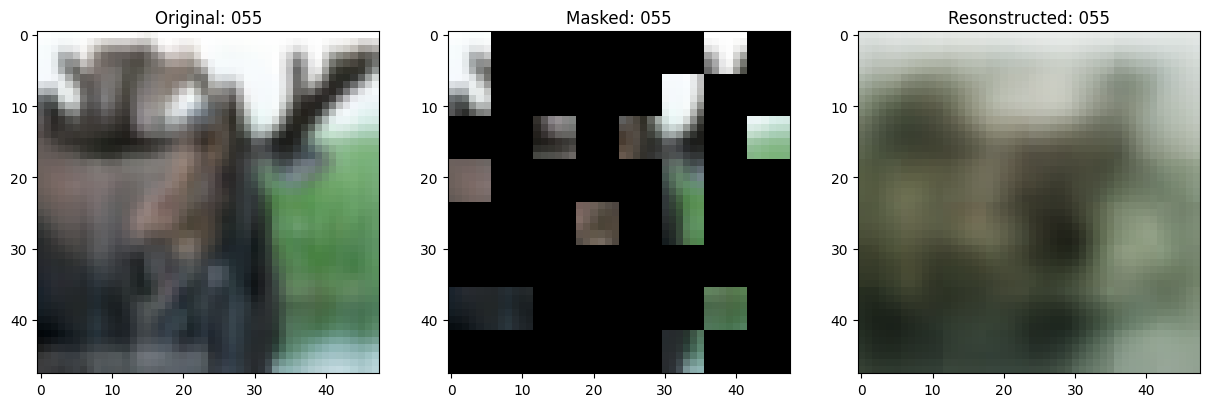

157/157 [==============================] - 9s 59ms/step - loss: 0.0143 - mae: 0.0849 - val_loss: 0.0157 - val_mae: 0.0891
Epoch 57/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0142 - mae: 0.0845 - val_loss: 0.0154 - val_mae: 0.0880
Epoch 58/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0142 - mae: 0.0846 - val_loss: 0.0153 - val_mae: 0.0882
Epoch 59/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0141 - mae: 0.0843 - val_loss: 0.0156 - val_mae: 0.0888
Epoch 60/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0140 - mae: 0.0839 - val_loss: 0.0151 - val_mae: 0.0872
Epoch 61/100
156/157 [============================>.] - ETA: 0s - loss: 0.0139 - mae: 0.0837
Idx chosen: 159


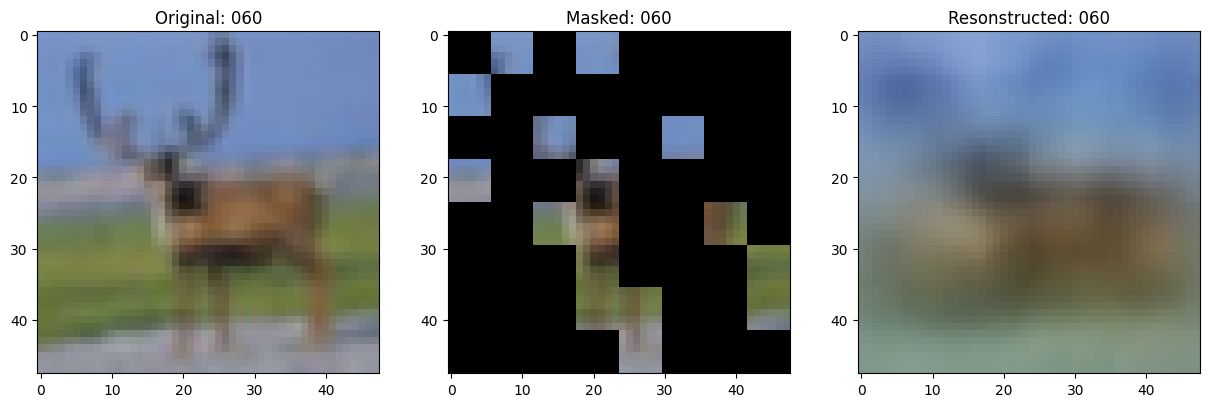

157/157 [==============================] - 9s 59ms/step - loss: 0.0139 - mae: 0.0836 - val_loss: 0.0151 - val_mae: 0.0868
Epoch 62/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0139 - mae: 0.0835 - val_loss: 0.0151 - val_mae: 0.0870
Epoch 63/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0139 - mae: 0.0835 - val_loss: 0.0153 - val_mae: 0.0871
Epoch 64/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0138 - mae: 0.0830 - val_loss: 0.0151 - val_mae: 0.0865
Epoch 65/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0138 - mae: 0.0829 - val_loss: 0.0151 - val_mae: 0.0866
Epoch 66/100
156/157 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0827
Idx chosen: 95


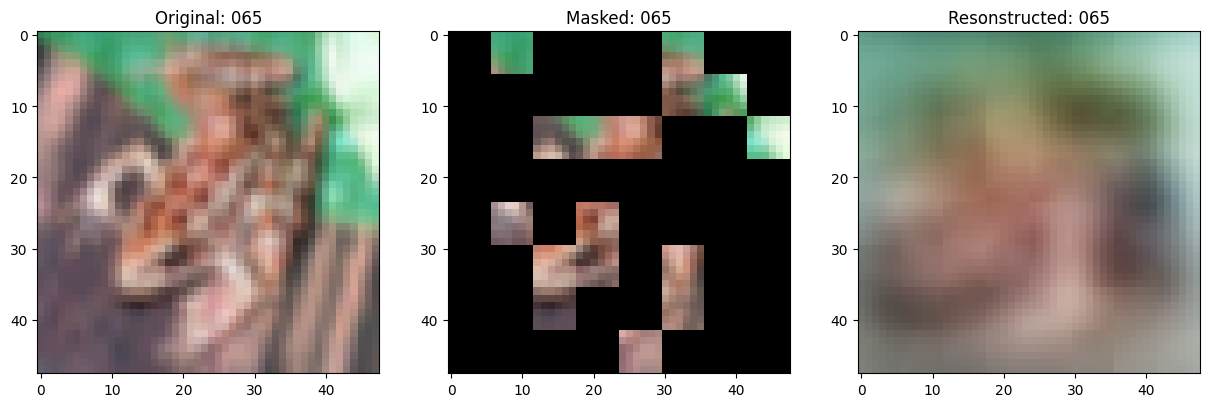

157/157 [==============================] - 9s 58ms/step - loss: 0.0137 - mae: 0.0827 - val_loss: 0.0154 - val_mae: 0.0878
Epoch 67/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0136 - mae: 0.0824 - val_loss: 0.0149 - val_mae: 0.0863
Epoch 68/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0136 - mae: 0.0822 - val_loss: 0.0148 - val_mae: 0.0863
Epoch 69/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0135 - mae: 0.0819 - val_loss: 0.0150 - val_mae: 0.0868
Epoch 70/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0135 - mae: 0.0818 - val_loss: 0.0150 - val_mae: 0.0864
Epoch 71/100
156/157 [============================>.] - ETA: 0s - loss: 0.0134 - mae: 0.0815
Idx chosen: 215


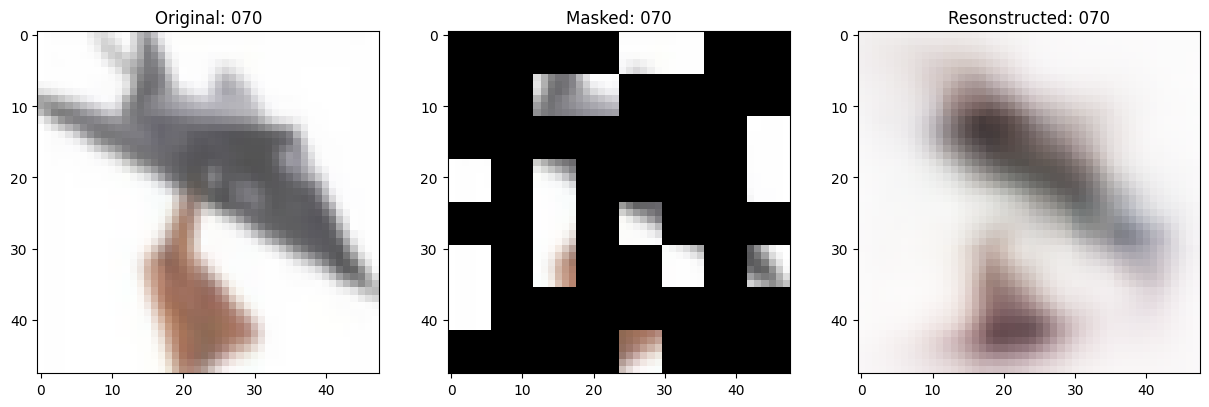

157/157 [==============================] - 9s 60ms/step - loss: 0.0134 - mae: 0.0815 - val_loss: 0.0148 - val_mae: 0.0859
Epoch 72/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0134 - mae: 0.0813 - val_loss: 0.0148 - val_mae: 0.0857
Epoch 73/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0133 - mae: 0.0812 - val_loss: 0.0147 - val_mae: 0.0856
Epoch 74/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0133 - mae: 0.0810 - val_loss: 0.0147 - val_mae: 0.0855
Epoch 75/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0132 - mae: 0.0808 - val_loss: 0.0146 - val_mae: 0.0851
Epoch 76/100
156/157 [============================>.] - ETA: 0s - loss: 0.0132 - mae: 0.0805
Idx chosen: 232


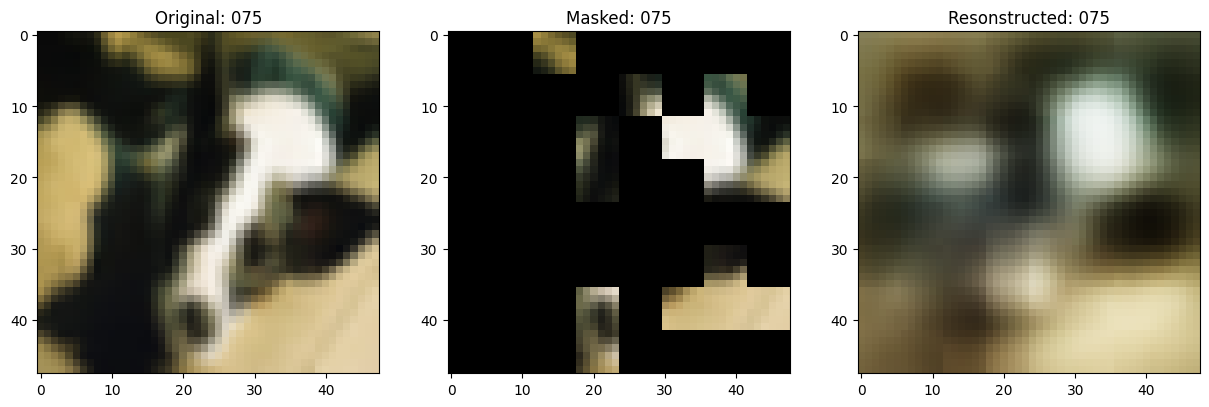

157/157 [==============================] - 9s 59ms/step - loss: 0.0132 - mae: 0.0805 - val_loss: 0.0148 - val_mae: 0.0857
Epoch 77/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0131 - mae: 0.0803 - val_loss: 0.0146 - val_mae: 0.0851
Epoch 78/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0131 - mae: 0.0802 - val_loss: 0.0146 - val_mae: 0.0846
Epoch 79/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0130 - mae: 0.0799 - val_loss: 0.0145 - val_mae: 0.0844
Epoch 80/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0131 - mae: 0.0800 - val_loss: 0.0145 - val_mae: 0.0842
Epoch 81/100
156/157 [============================>.] - ETA: 0s - loss: 0.0130 - mae: 0.0796
Idx chosen: 179


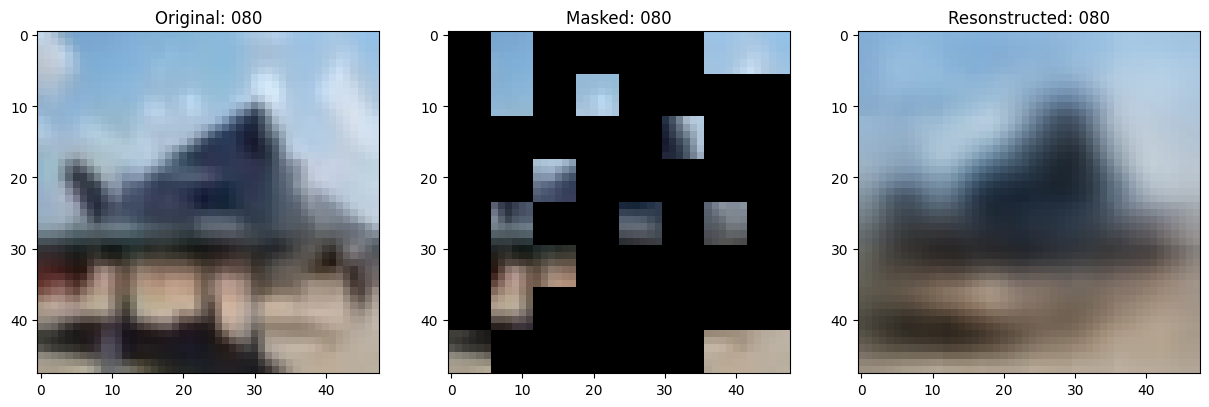

157/157 [==============================] - 9s 59ms/step - loss: 0.0130 - mae: 0.0796 - val_loss: 0.0144 - val_mae: 0.0838
Epoch 82/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0129 - mae: 0.0795 - val_loss: 0.0144 - val_mae: 0.0835
Epoch 83/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0129 - mae: 0.0793 - val_loss: 0.0143 - val_mae: 0.0837
Epoch 84/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0129 - mae: 0.0792 - val_loss: 0.0144 - val_mae: 0.0838
Epoch 85/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0128 - mae: 0.0788 - val_loss: 0.0144 - val_mae: 0.0841
Epoch 86/100
156/157 [============================>.] - ETA: 0s - loss: 0.0128 - mae: 0.0789
Idx chosen: 112


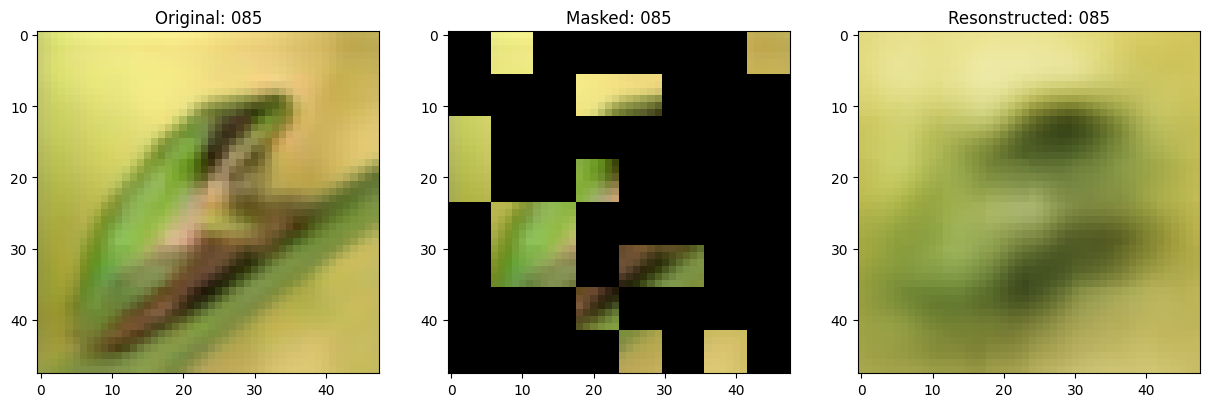

157/157 [==============================] - 9s 59ms/step - loss: 0.0128 - mae: 0.0789 - val_loss: 0.0144 - val_mae: 0.0839
Epoch 87/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0127 - mae: 0.0786 - val_loss: 0.0142 - val_mae: 0.0833
Epoch 88/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0128 - mae: 0.0786 - val_loss: 0.0142 - val_mae: 0.0831
Epoch 89/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0127 - mae: 0.0784 - val_loss: 0.0142 - val_mae: 0.0830
Epoch 90/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0127 - mae: 0.0783 - val_loss: 0.0141 - val_mae: 0.0828
Epoch 91/100
156/157 [============================>.] - ETA: 0s - loss: 0.0127 - mae: 0.0783
Idx chosen: 61


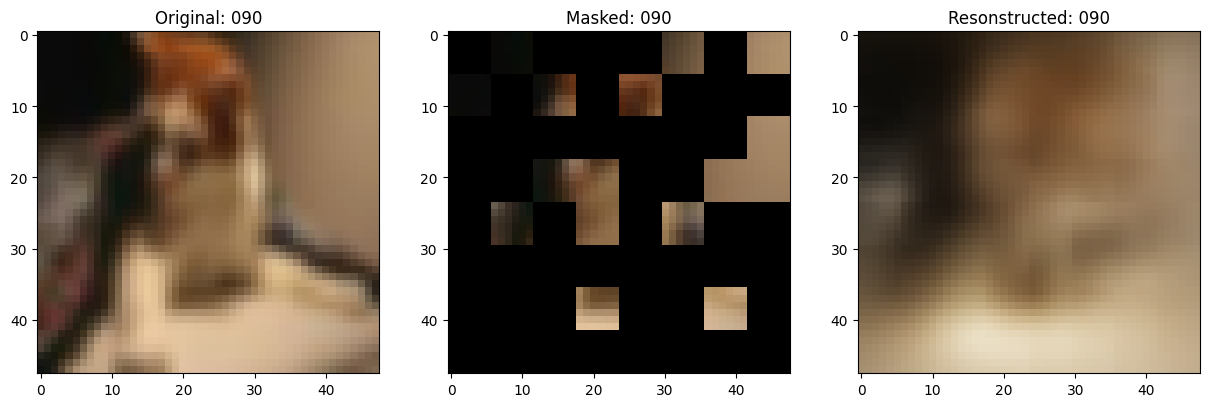

157/157 [==============================] - 9s 58ms/step - loss: 0.0127 - mae: 0.0782 - val_loss: 0.0142 - val_mae: 0.0831
Epoch 92/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0126 - mae: 0.0781 - val_loss: 0.0142 - val_mae: 0.0831
Epoch 93/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0126 - mae: 0.0782 - val_loss: 0.0141 - val_mae: 0.0830
Epoch 94/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0127 - mae: 0.0782 - val_loss: 0.0142 - val_mae: 0.0829
Epoch 95/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0126 - mae: 0.0782 - val_loss: 0.0142 - val_mae: 0.0830
Epoch 96/100
156/157 [============================>.] - ETA: 0s - loss: 0.0126 - mae: 0.0783
Idx chosen: 240


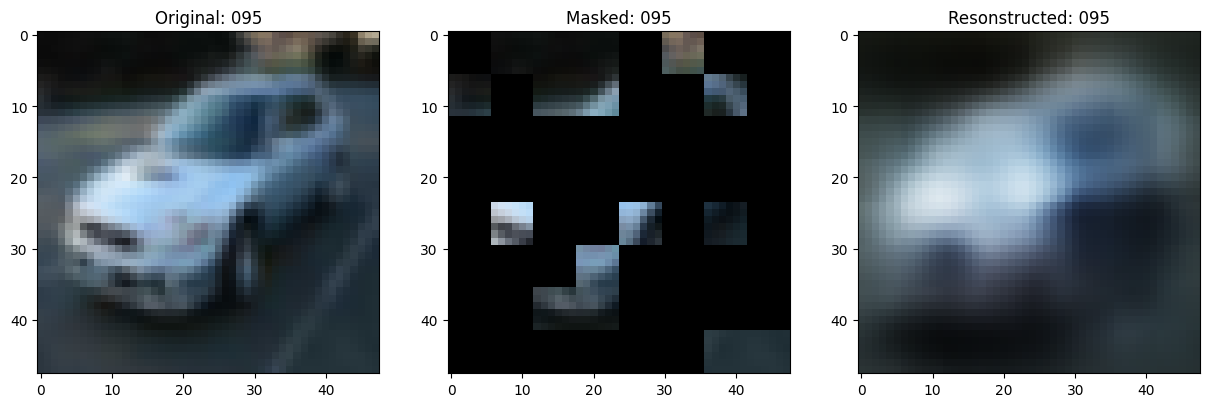

157/157 [==============================] - 9s 58ms/step - loss: 0.0126 - mae: 0.0783 - val_loss: 0.0142 - val_mae: 0.0831
Epoch 97/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0127 - mae: 0.0786 - val_loss: 0.0143 - val_mae: 0.0833
Epoch 98/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0128 - mae: 0.0788 - val_loss: 0.0143 - val_mae: 0.0837
Epoch 99/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0129 - mae: 0.0793 - val_loss: 0.0143 - val_mae: 0.0841
Epoch 100/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0130 - mae: 0.0805 - val_loss: 0.0145 - val_mae: 0.0855


In [18]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

In [19]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 1s 19ms/step - loss: 0.0146 - mae: 0.0856
Loss: 0.01
MAE: 0.09


# Downstrean Task

In [20]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_pre (PatchesPre)    (None, 64, 108)           0         
                                                                 
 patch_encoder_pre (PatchEnc  (None, 64, 128)          22252     
 oderPre)                                                        
                                                                 
 mae_encoder (Functional)    (None, None, 128)         990976    
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [21]:
train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [22]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 12s 57ms/step - loss: 2.2739 - accuracy: 0.1490 - val_loss: 2.0692 - val_accuracy: 0.2747
Epoch 2/50
157/157 [==============================] - 8s 52ms/step - loss: 1.9503 - accuracy: 0.3308 - val_loss: 1.8251 - val_accuracy: 0.3740
Epoch 3/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7950 - accuracy: 0.3842 - val_loss: 1.7266 - val_accuracy: 0.4032
Epoch 4/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7251 - accuracy: 0.4067 - val_loss: 1.6772 - val_accuracy: 0.4161
Epoch 5/50
157/157 [==============================] - 8s 54ms/step - loss: 1.6870 - accuracy: 0.4142 - val_loss: 1.6450 - val_accuracy: 0.4252
Epoch 6/50
157/157 [==============================] - 8s 53ms/step - loss: 1.6598 - accuracy: 0.4205 - val_loss: 1.6225 - val_accuracy: 0.4315
Epoch 7/50
157/157 [==============================] - 8s 53ms/step - loss: 1.6422 - accuracy: 0.4266 - val_loss: 1.6056 - val_accuracy: 0.435


KeyboardInterrupt



In [ ]:
downstream_model.save(f"linear_probe_{timestamp}", include_optimizer=False)